
## The Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines. They collect four kinds of time series data for each machine in their fleet. When a machine is operating in normal mode the data behaves in a fairly predictable way, but with a moderate amount of noise. Before a machine fails it will ramp into faulty mode, during which the data appears visibly quite different. Finally, when a machine fails it enters a third, and distinctly different, failed mode where all signals are very close to zero. There are four common sensors associated with each machine. There is also static data associated with each machine.

ExampleCo stores their data in SQL tables. While SQL is useful for storing and querying data, it is less useful as input for machine learning pipelines. At Tagup, our ML Pipelines expect data as an n-dimensional array, and a common first step is converting a customer's data from SQL to array form.

You can download the data here: [exampleco_data](https://drive.google.com/file/d/1GejVDBoFFVNprqMeTGnXu8hrYLj4aS4q/view?usp=sharing)

Your objectives are:

- Map the equipment data from SQL into arrays (or a single array). To keep things simple, you can ignore the static data to start. Be sure to describe your design choices and the array schema you chose.
- Apply filters to clean the data. There are some clear outliers in the data due to communication errors from the sensor equipment. A good place to start is to find a way to filter them out.
- Explain why your design and approach is effective, in language a non-technical executive can understand. If helpful, use visualizations to demonstrate the efficacy of your approach.

Bonus points:
- Integrate the static data into your design.
- Provide summary statistics for the ingressed data, including various statistical moments, and any other relevant descriptive statistics.
- As part of a data processing pipeline, upload your arrays to AWS S3.
    
A few notes to help:
1. Feel free to use any libraries you like. At Tagup, we use [xarray](http://xarray.pydata.org/en/stable/) for multidimensional arrays, but you can use whatever methods you prefer. Your final results should be shared via GitHub, including a README file providing documentation (ideally of both your code and your findings in the data). There is a jupyter notebook included to help you get started, but do not feel obligated to submit your solution in notebook form.
    
2. There are no constraints on the techniques you bring to bear, we are curious to see how you think and what sort of resources you have in your toolbox.
    
3. Don't hesitate to reach out to challenges@tagup.io with any questions!
    

## Tips
- We value syntax, structure and variable naming, code documentation, and testability.
- Try to design and implement your solution as you would do for real production code. Show us how you create clean and maintainable code that produces the target result. Build something that we'd be happy to contribute to.
- Feel free to add more features: we're curious about what you can think of. We'd expect the same if you worked with us!


# Set Up

In [1]:
# import libraries

## manipulate labelled N-D arrays
import xarray as xr

## manipulate unlabelled N-D arrays with more matplotlib plotting support
import pandas as pd

## import and query from SQL databases
from sqlalchemy import create_engine, inspect, MetaData, Table

## perform fast array operations
import numpy as np

## plot from pandas dataframes
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# If running in google colab, the following enables files to be accesed from and saved directly to a google drive folder. Adjust accordingly to save output files elsewhere.
from google.colab import drive
drive.mount('/content/drive')
PARENT_DIR = '/content/drive/MyDrive/TagUpChallenge/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Database


In [3]:
# Load db. Replace PARENT_DIR with location of exampleco_db.db
engine = create_engine('sqlite:///' + PARENT_DIR + 'exampleco_db.db', echo=False)

In [4]:
# View tables
inspector = inspect(engine)
inspector.get_table_names()

['feat_0', 'feat_1', 'feat_2', 'feat_3', 'static_data']

# Convert Data to Arrays

In [5]:
# convert machine info to pandas DataFrame and save as CSV file

## extract all data from static_data table
query = "SELECT * FROM static_data;"
static_data = engine.execute(query).fetchall()

## save table data as pandas DataFrame
machine_info = pd.DataFrame(static_data, columns=['machine', 'time', 'model', 'room'])

## save "time" varibale as datetime type 
machine_info['time'] = pd.to_datetime(machine_info['time'])

## save "machine" variable as integer
machine_info['machine'] = machine_info['machine'].map(lambda s: s.split('_')[1]).astype(int)

## save "model" variable as letter A or B
machine_info['model'] = machine_info['model'].map(lambda s: s.split(' ')[1])

## save "room" variable as integer
machine_info['room'] = machine_info['room'].map(lambda s: s.split(' ')[1]).astype(int)

## save DataFrame as CSV file
machine_info.to_csv(PARENT_DIR + 'machine_info.csv')

In [6]:
# array of feature names
feats = ['feat_0', 'feat_1', 'feat_2', 'feat_3']

In [7]:
# create an xarray DataArray for each feature

## list of DataArrays for each feature
xarrays = []

for feat in feats:
  ## select all data from table corresponding to feature
  query = f"SELECT * FROM {feat};"
  feat_data = engine.execute(query).fetchall()

  ## save table data as a pandas DataFrame
  feat_data = pd.DataFrame(feat_data, columns = ['time', 'machine', feat])

  ## save "time" variable as a datetime type
  feat_data['time'] = pd.to_datetime(feat_data['time'])

  ## Save "machine" variable as integer. This forces plots to order facets correctly. (xarray does not appear to allow factor types)
  feat_data['machine'] = feat_data['machine'].map(lambda s: s.split('_')[1]).astype(int)

  ## convert table data from Pandas dataframe to xarray DataArray
  feat_data = feat_data.set_index(['time', 'machine']).to_xarray()

  ## append DataArray to list
  xarrays.append(feat_data)

## Merge list of DataArrays into a single DataSet with each feature as a DataArray
data = xr.merge(xarrays)

# Data Cleaning

<Figure size 432x288 with 0 Axes>

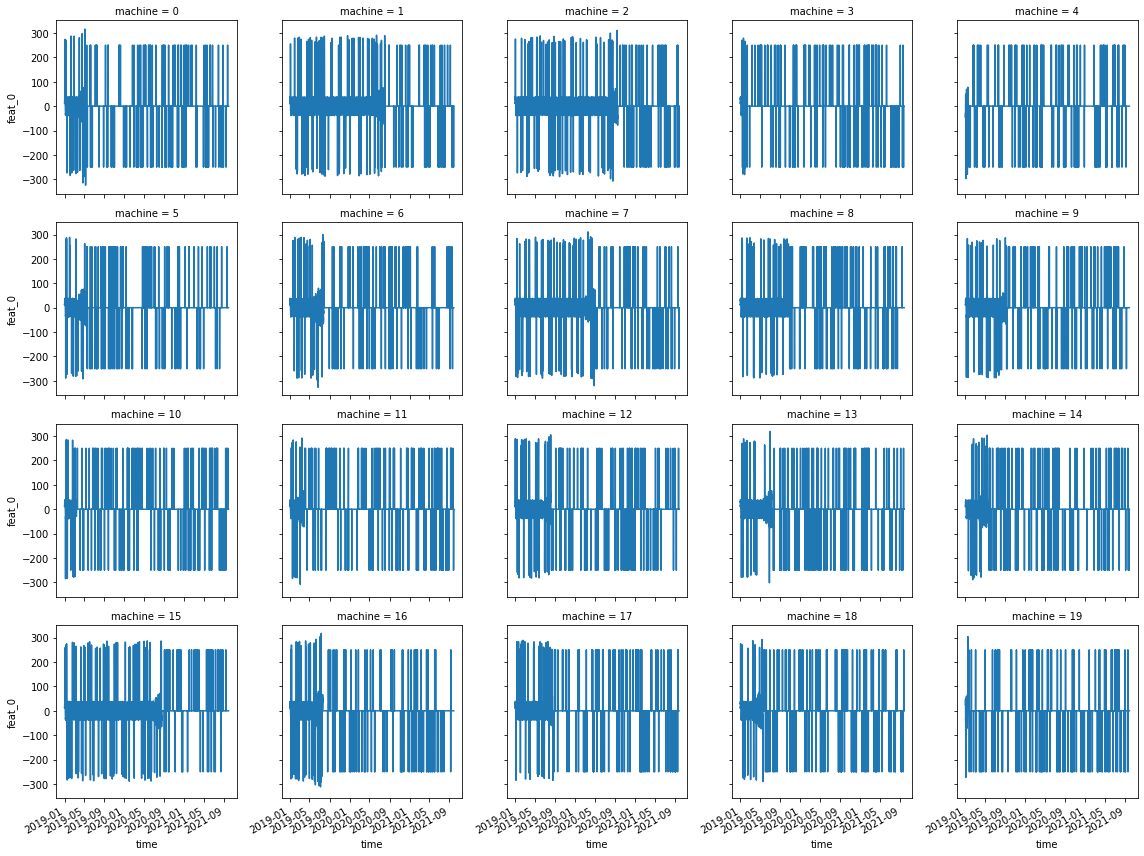

<Figure size 432x288 with 0 Axes>

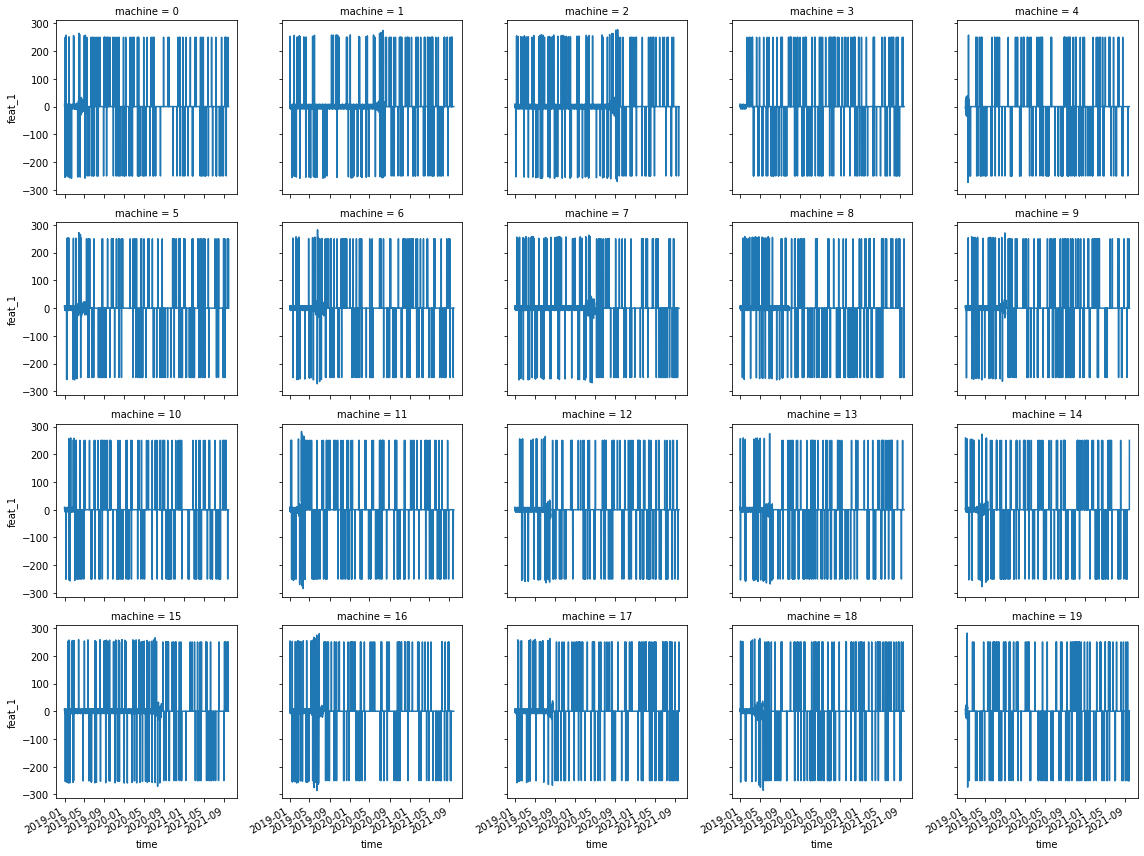

<Figure size 432x288 with 0 Axes>

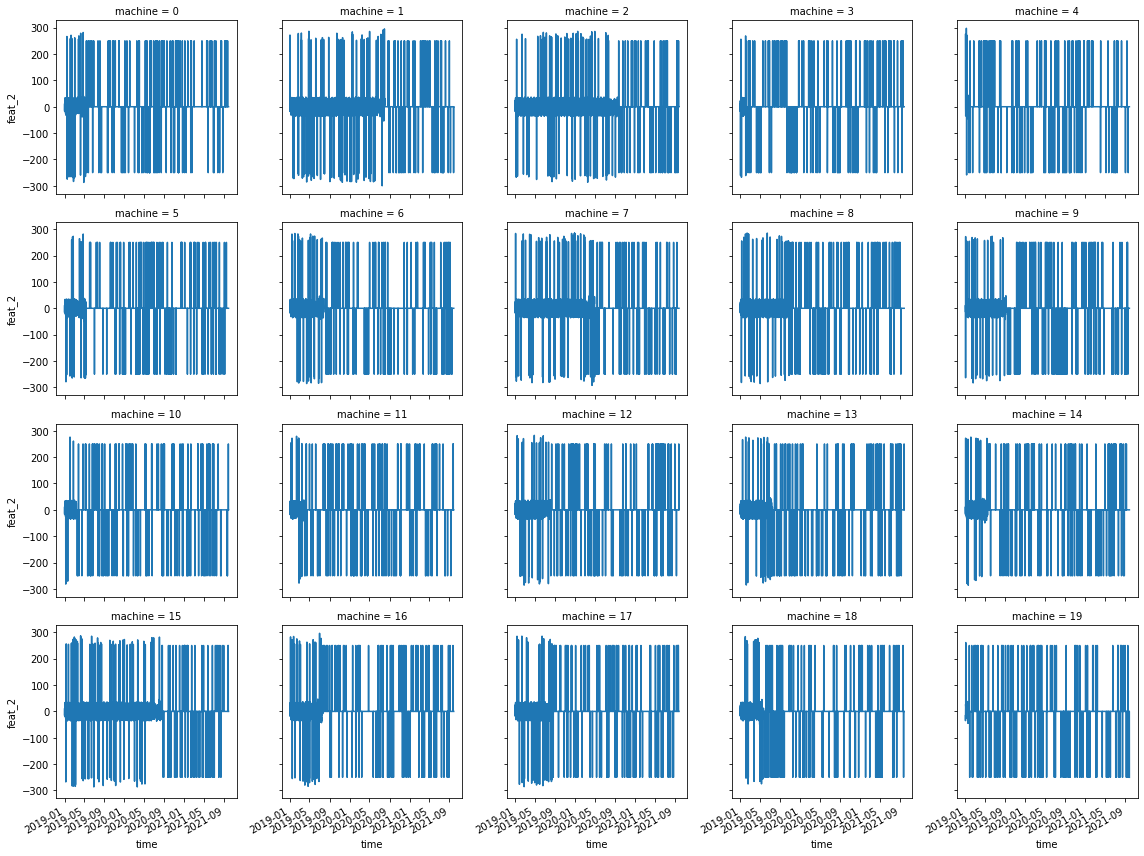

<Figure size 432x288 with 0 Axes>

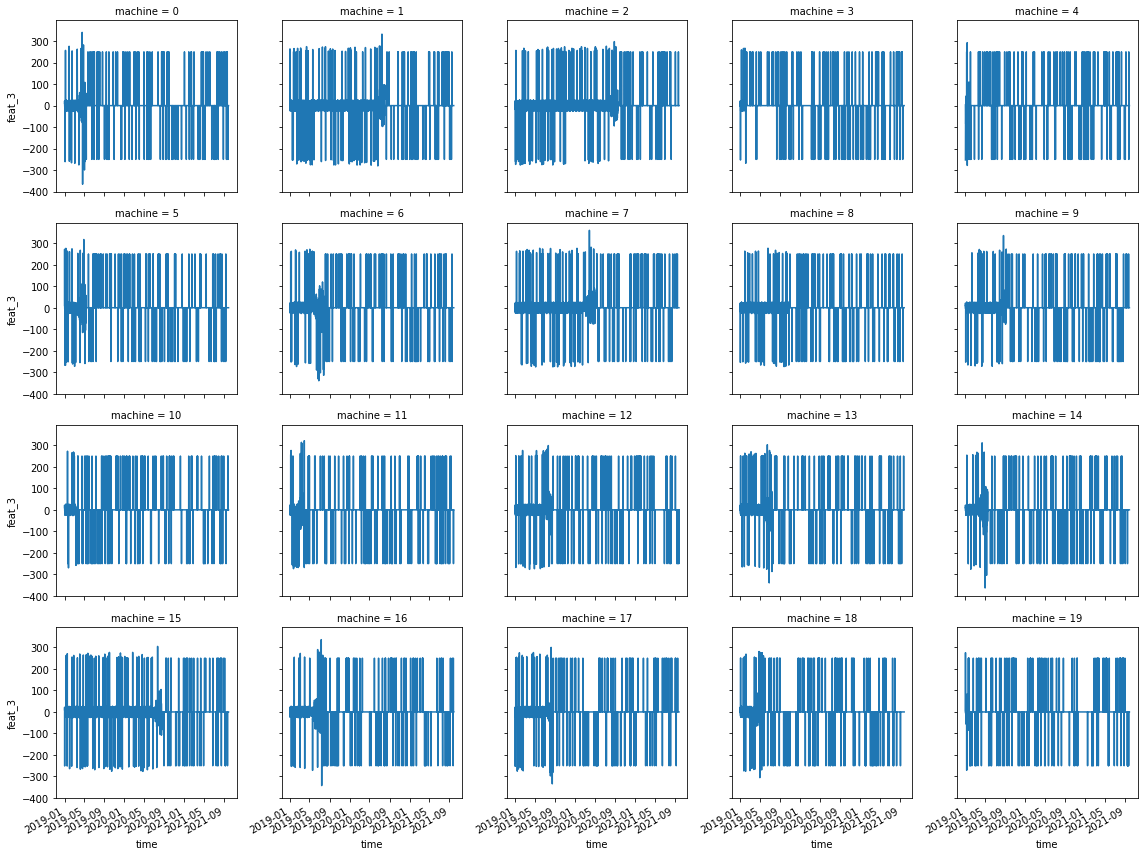

In [8]:
## Figures 1a-1d. Raw data over time, facetted by machine. Separate figures for each feature.
for feat, fig in zip(feats, ['a','b','c','d']):
  plt.figure()
  data[feat].plot(x='time',col='machine', col_wrap=5)
  plt.savefig(PARENT_DIR + '/figures/1'+ fig)

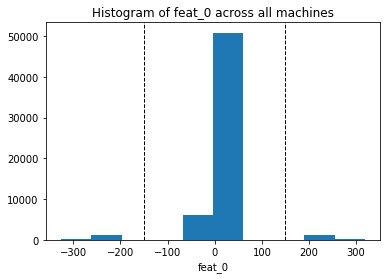

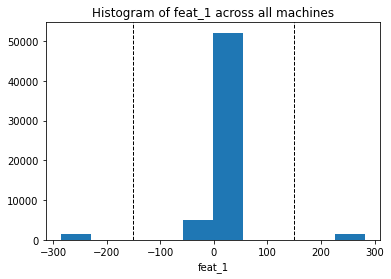

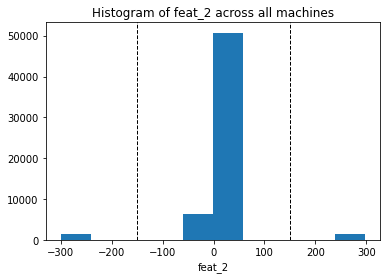

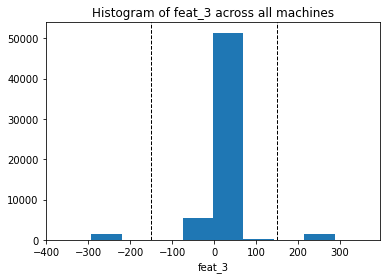

In [9]:
# figures 2a-2d. Histogram of data values by feature. Aggregated across machines and across time. Vertical lines represent outlier threshold.
for feat, fig in zip(feats, ['a','b','c','d']):
  plt.figure()
  data[feat].plot.hist()
  plt.title('Histogram of ' + feat + ' across all machines')
  plt.axvline(150, color='k', linestyle='dashed', linewidth=1)
  plt.axvline(-150, color='k', linestyle='dashed', linewidth=1)
  plt.savefig(PARENT_DIR + '/figures/2'+ fig)

In [10]:
# data cleaning - removal of outliers

## array of cleaned feature names
cleaned_feats = ['cleaned_' + feat for feat in feats]

## define cleaned feature variables by removing values exceeding 150
for feat, cfeat in zip(feats, cleaned_feats):
  data[cfeat] = data[feat].where(abs(data[feat]) < 150)

## compute percentage of data removed for each feature
pct_outliers = [(xr.where(data[feat] > 150, 1, 0).sum()/data[feat].count()).item() for feat in feats]

## convert outlier rates to pandas DataFrame
pct_outlier_table = pd.DataFrame({'feature' : feats, 'Percent Outliers' : pct_outliers})

## save outlier rates DataFrame as csv file
pct_outlier_table.to_csv(PARENT_DIR + 'pct_outlier_table.csv')

# Time-Series Visualization and Summary Statistics

<Figure size 432x288 with 0 Axes>

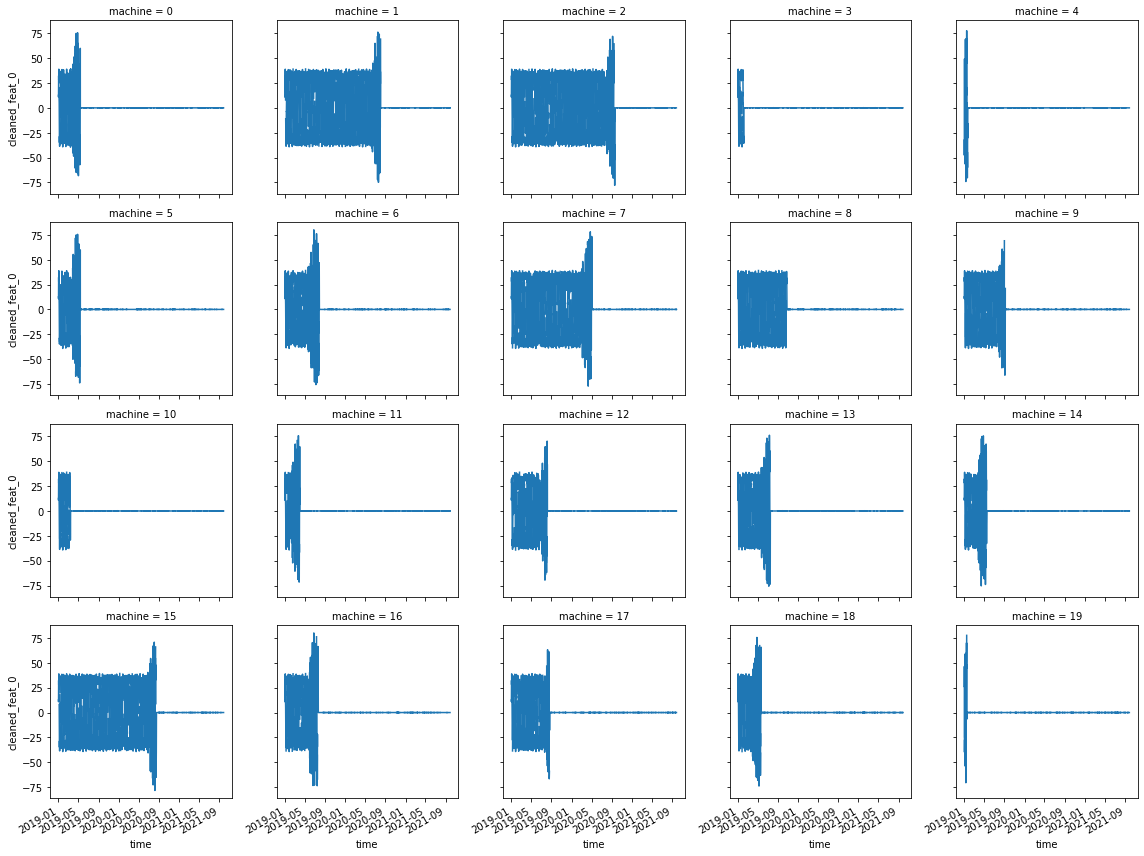

<Figure size 432x288 with 0 Axes>

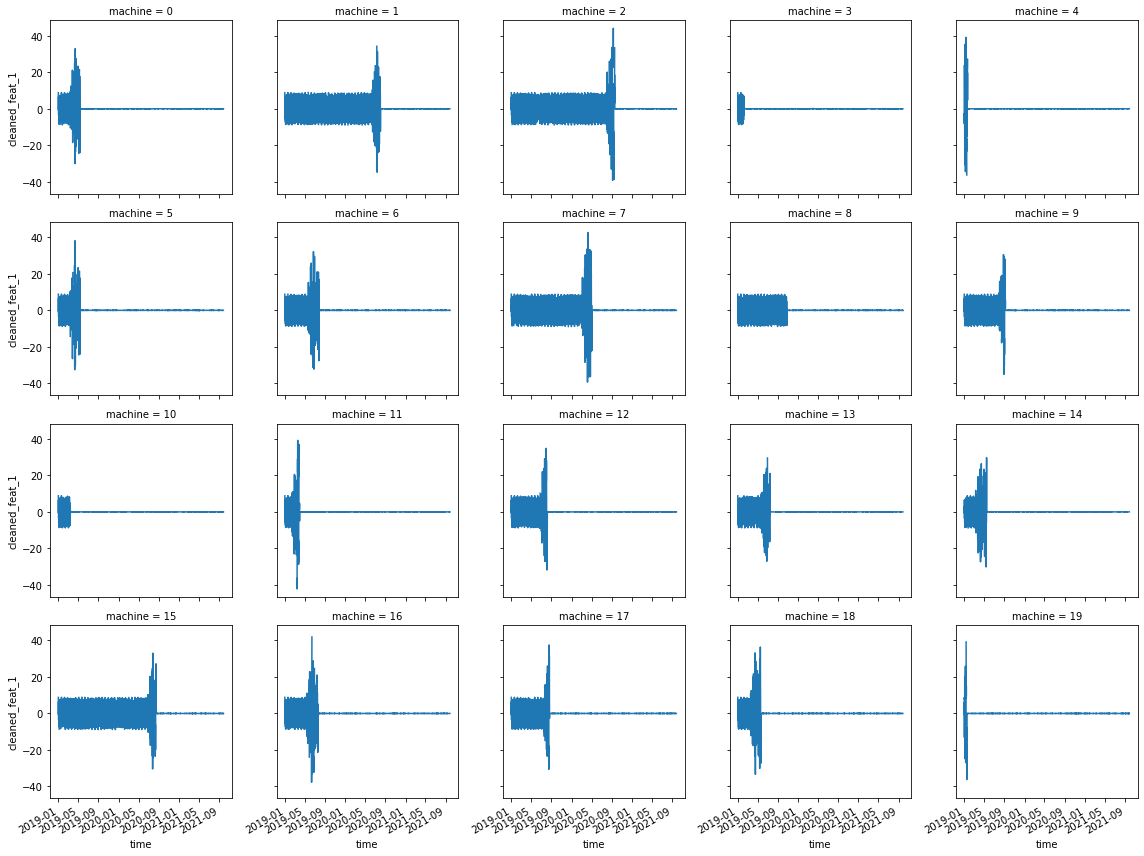

<Figure size 432x288 with 0 Axes>

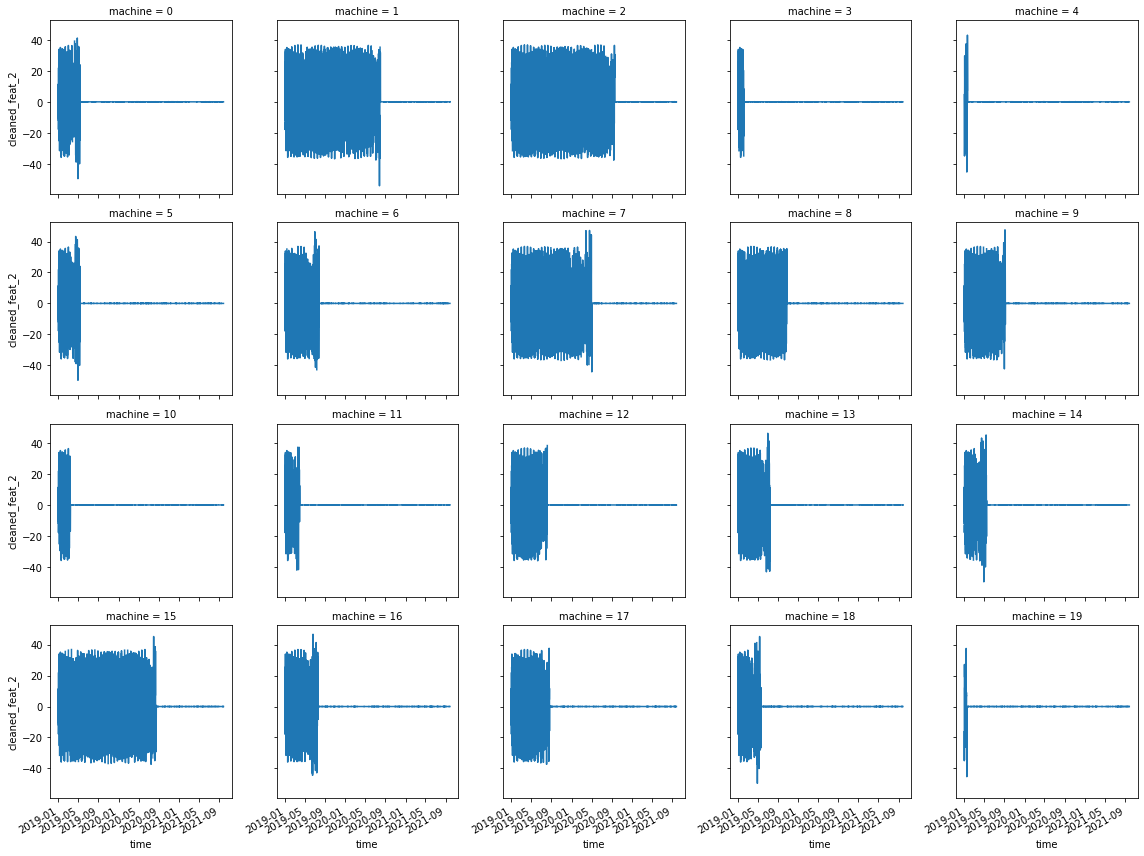

<Figure size 432x288 with 0 Axes>

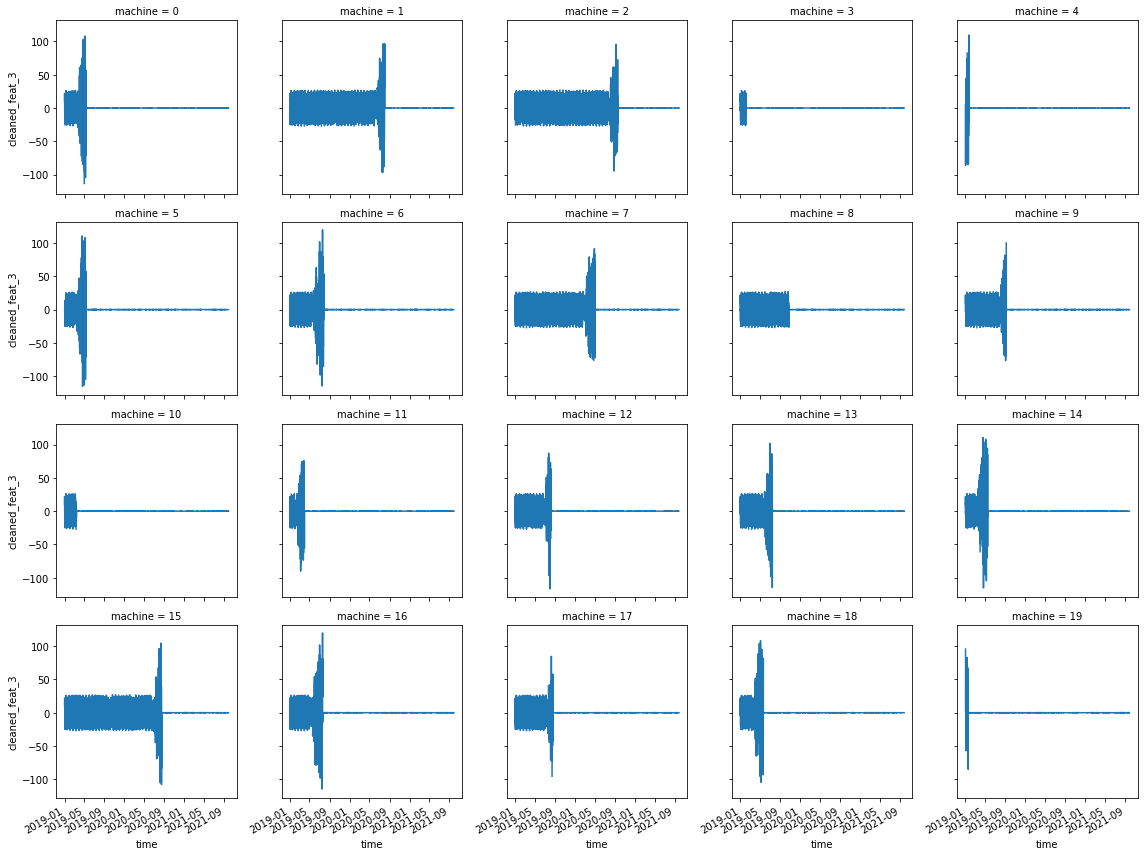

In [11]:
# Figure 3a-3d. Cleaned data over time, facetted by machine. Separate figures for each feature.
for cfeat, fig in zip(cleaned_feats, ['a','b','c','d']):
  plt.figure()
  data[cfeat].plot(x='time',col='machine', col_wrap=5)
  plt.savefig(PARENT_DIR + '/figures/3'+ fig)

In [12]:
# compute summary statistics 

## compute mean and standard deviation across time and machines for each feature
means = data[cleaned_feats].mean(dim = ['time', 'machine']).to_pandas()
stds = data[cleaned_feats].std(dim = ['time', 'machine']).to_pandas()

## convert summary statistics to pandas DataFrame 
summary_stats = pd.DataFrame({'feature' : feats, 'Mean' : means, 'Standard Dev.' : stds})

## save summary stats DataFrame as CSV file
summary_stats.to_csv(PARENT_DIR + 'summary_stats.csv')

# Identification of Machine Failure

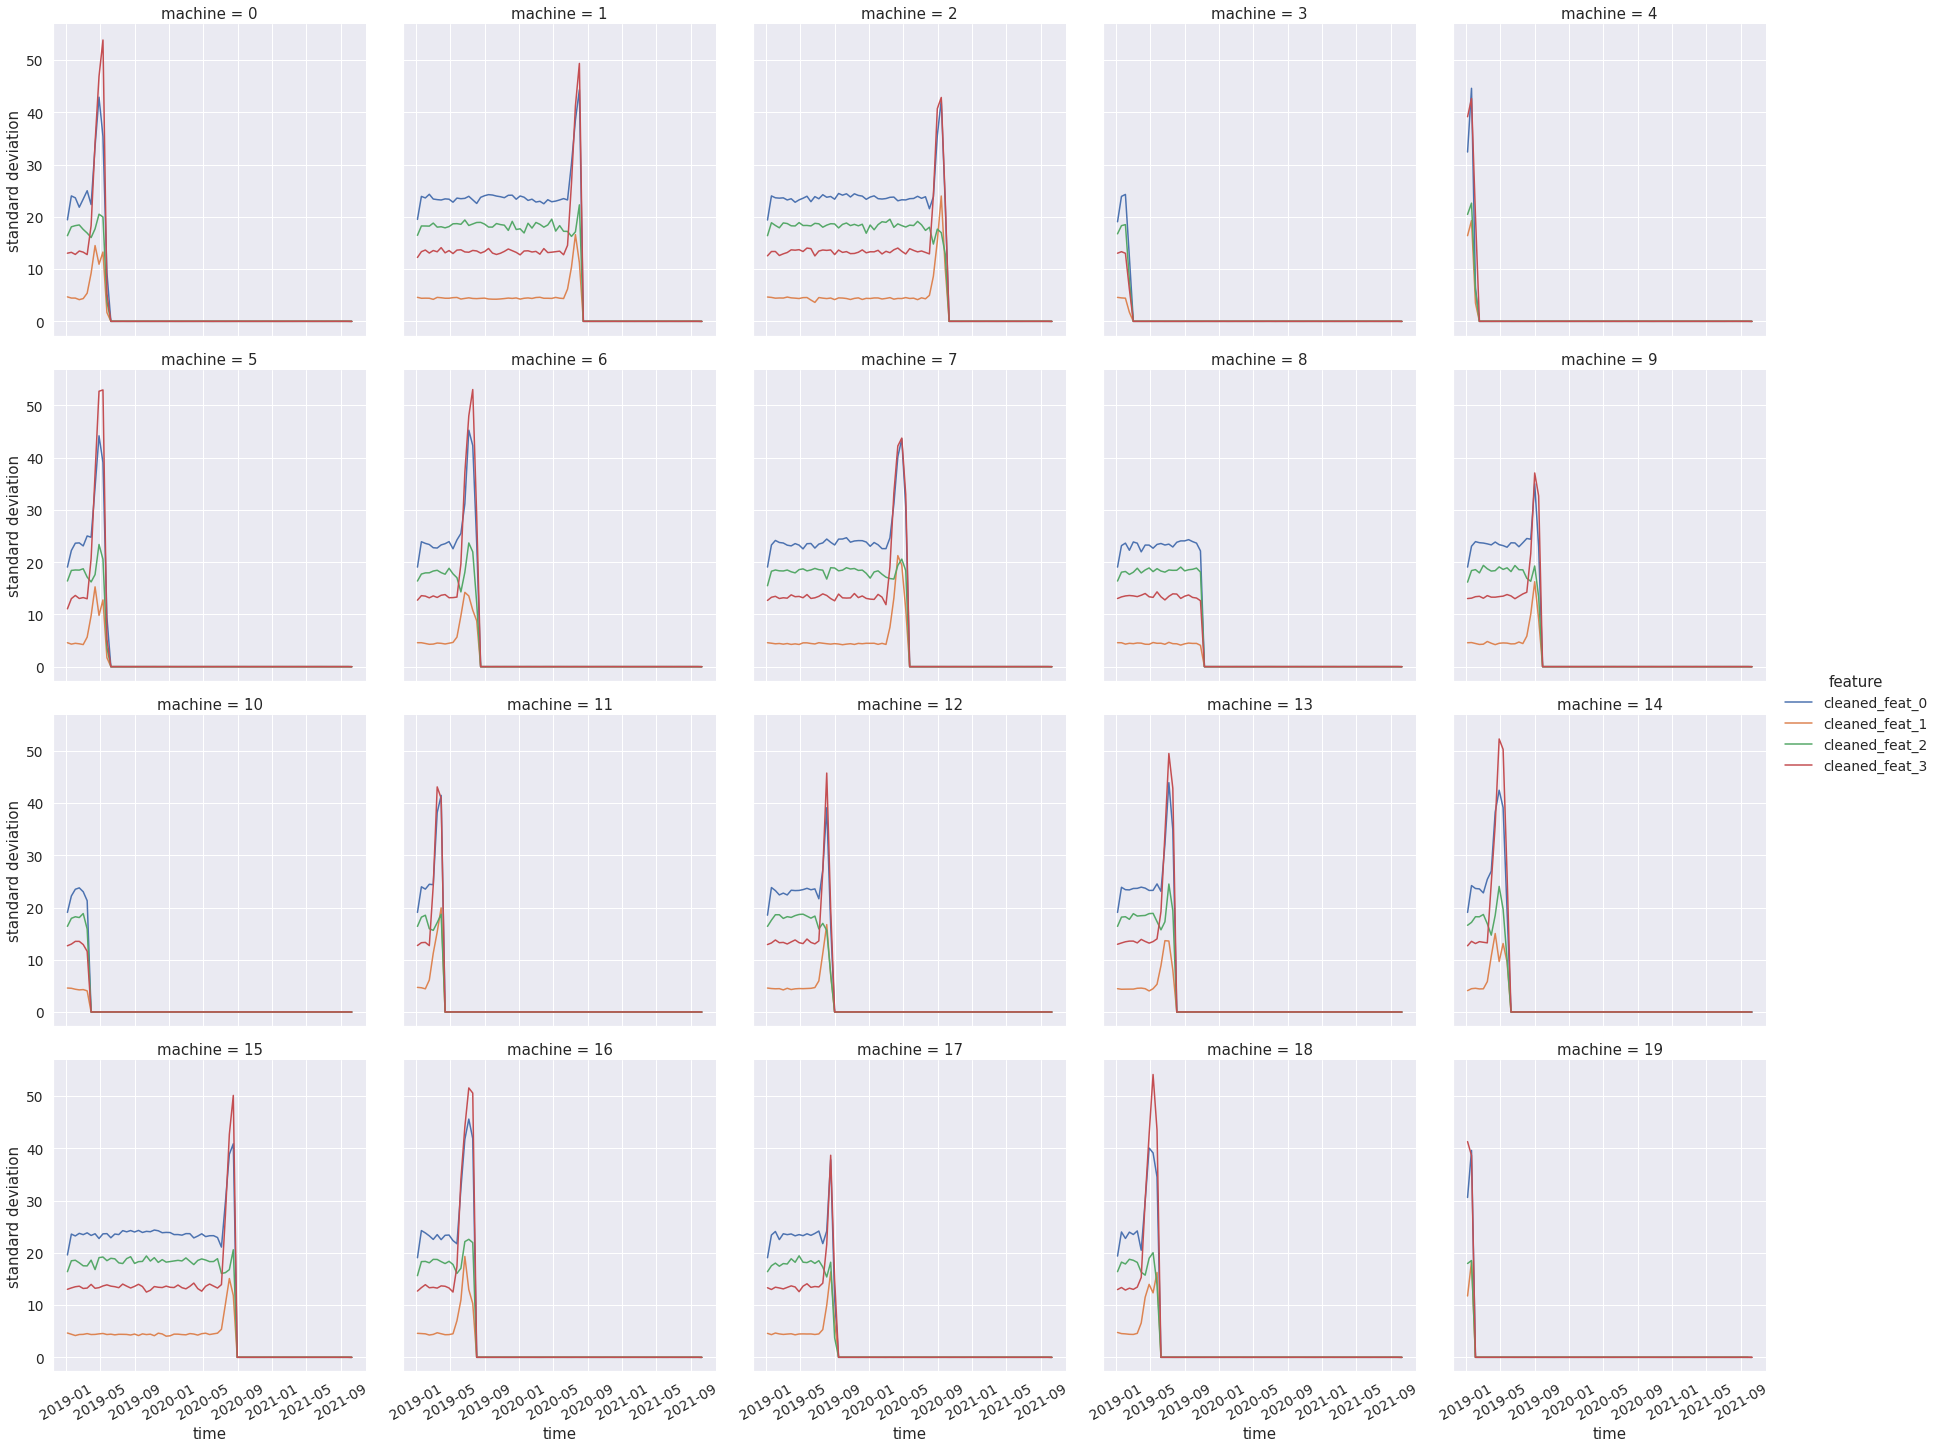

In [13]:
# standard deviation over time

## aggregate data by 2-week intervals and compute standard deviation for each machine and feature over time within these intervals
data_by_week = data.resample(time="2W").std(skipna = True)

## convert to pandas dataframe to use seaborn library. Reset index to enable ploting by time and machine
data_by_week_df = data_by_week[cleaned_feats].to_dataframe().reset_index()

## convert from wide to long format to enable plotting all features on the same axes
data_by_week_df_long = data_by_week_df.melt(id_vars=['time', 'machine'], value_vars = cleaned_feats, var_name='feature', value_name='standard deviation')

## Figure 5. Standard deviation of feature values (across two-week intervals) over time. Facetted by machine. Color represents feature.
sns.set(font_scale = 1.25)
plot = sns.relplot(x = 'time', y = 'standard deviation', col = 'machine', data = data_by_week_df_long, col_wrap = 5, kind = 'line', hue = 'feature')
for axes in plot.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
plt.savefig(PARENT_DIR + '/figures/4', bbox_inches = "tight")
sns.set()


In [14]:
# Determine "mode" of each machine

## Define the "mode" of the machine for each 2-week interval based on any feature's standard devation exceeding feature-specific threshold or being 0
data_by_week['mode'] = xr.where((data_by_week['cleaned_feat_0'] > 30) | (data_by_week['cleaned_feat_1'] > 10) | 
                                (data_by_week['cleaned_feat_2'] > 20) | (data_by_week['cleaned_feat_3'] > 20), 
                                'faulty', 
                                xr.where((data_by_week['cleaned_feat_0'] < 1)| (data_by_week['cleaned_feat_1'] < 1) | 
                                         (data_by_week['cleaned_feat_2'] < 1) | (data_by_week['cleaned_feat_3'] < 1), 
                                         'failed', 'normal'))

## Interplotate mode across two-week intervals to enable merging with original data
mode = data_by_week.interp(time=data.time).mode

## define mode as a DataArray in the original dataset
data['mode'] = mode

<Figure size 432x288 with 0 Axes>

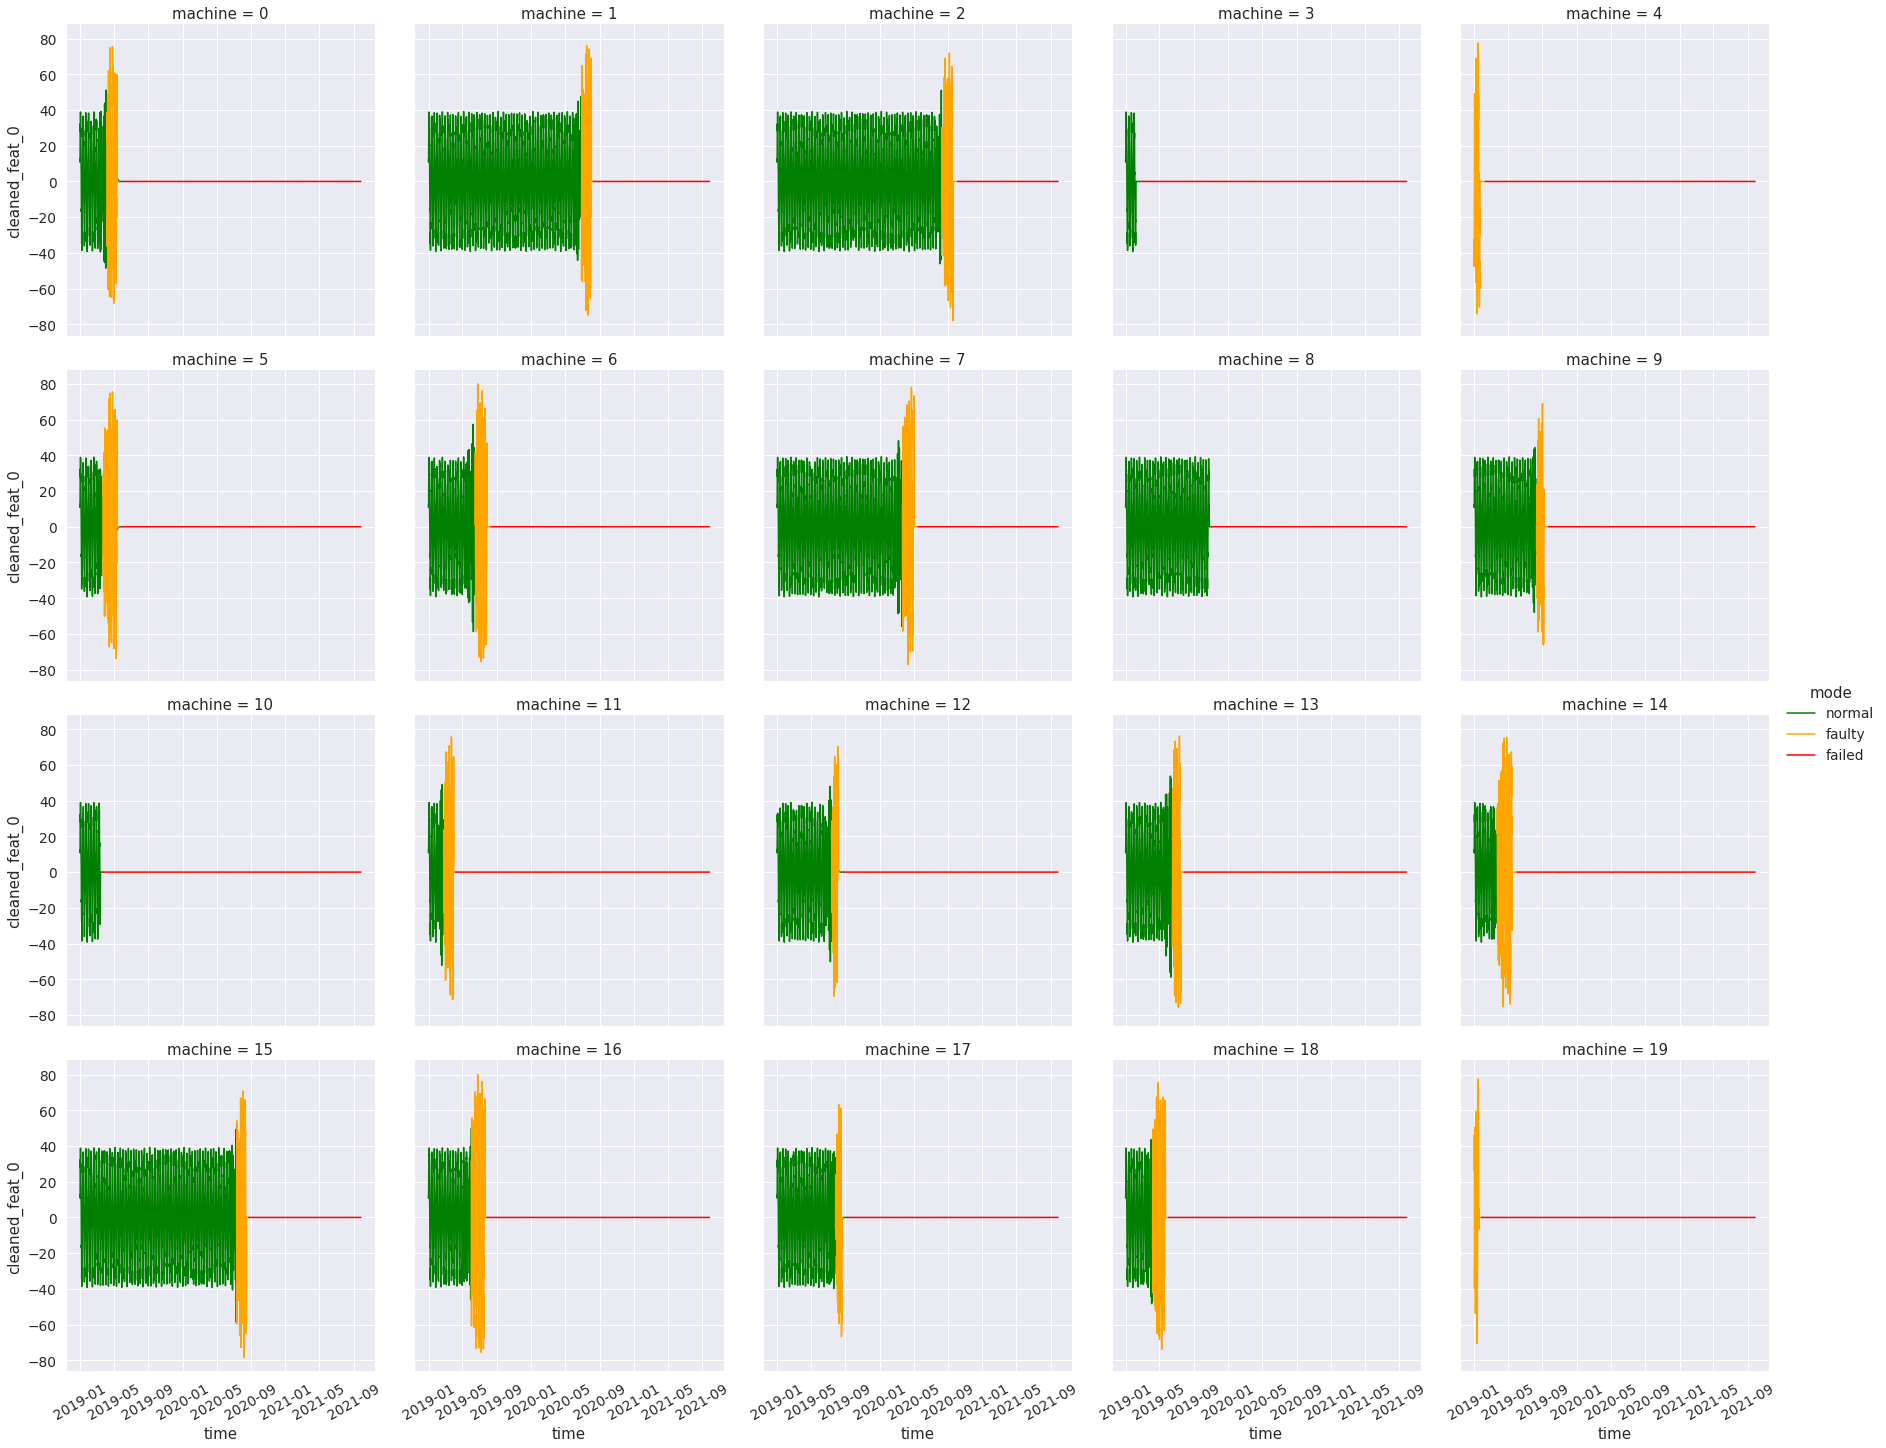

<Figure size 432x288 with 0 Axes>

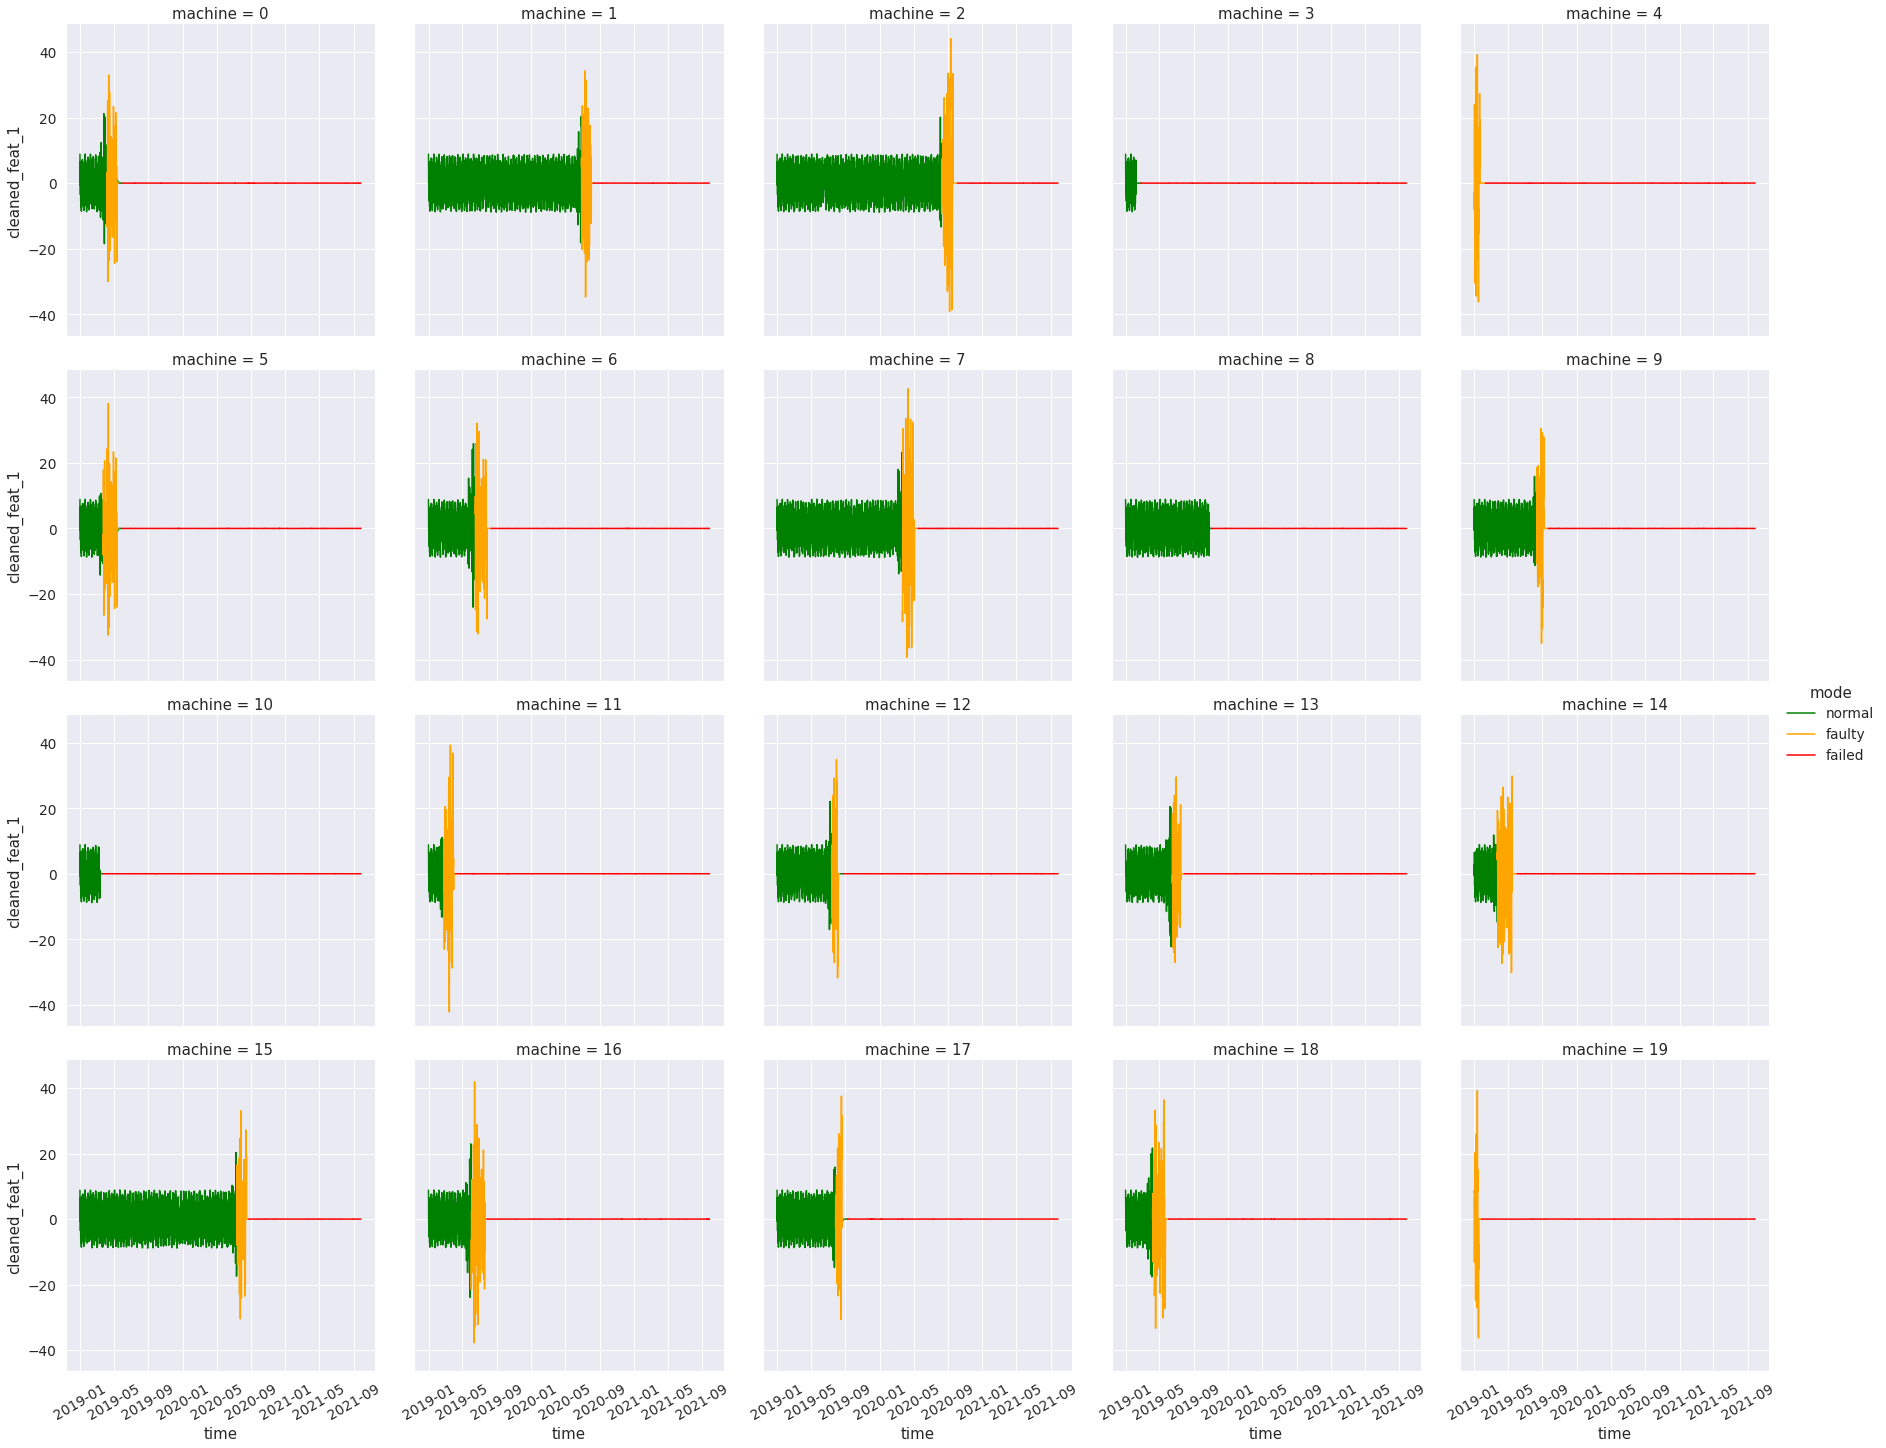

<Figure size 432x288 with 0 Axes>

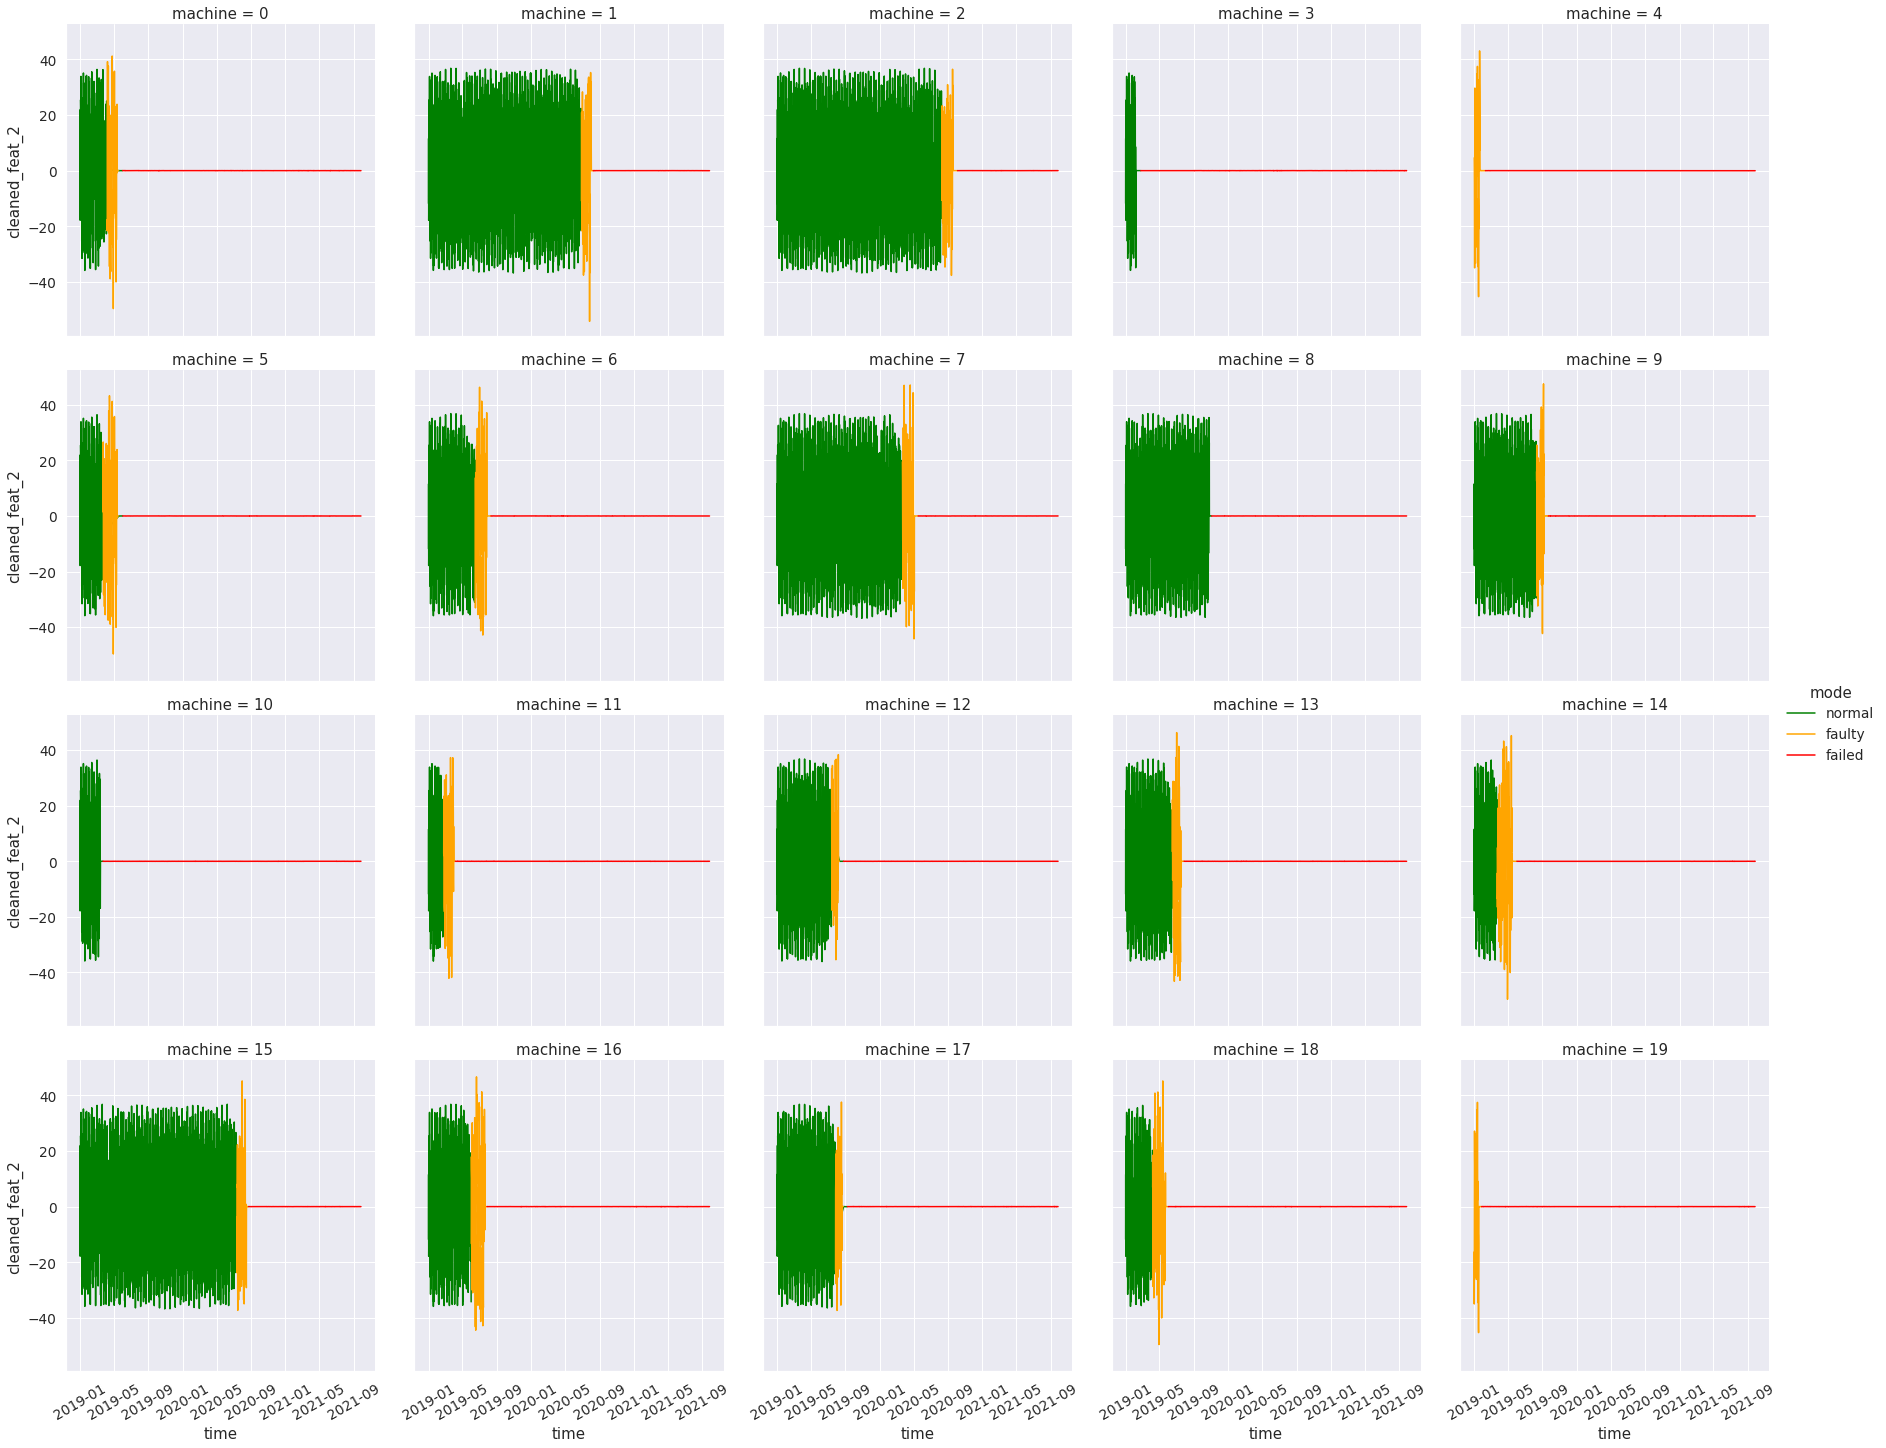

<Figure size 432x288 with 0 Axes>

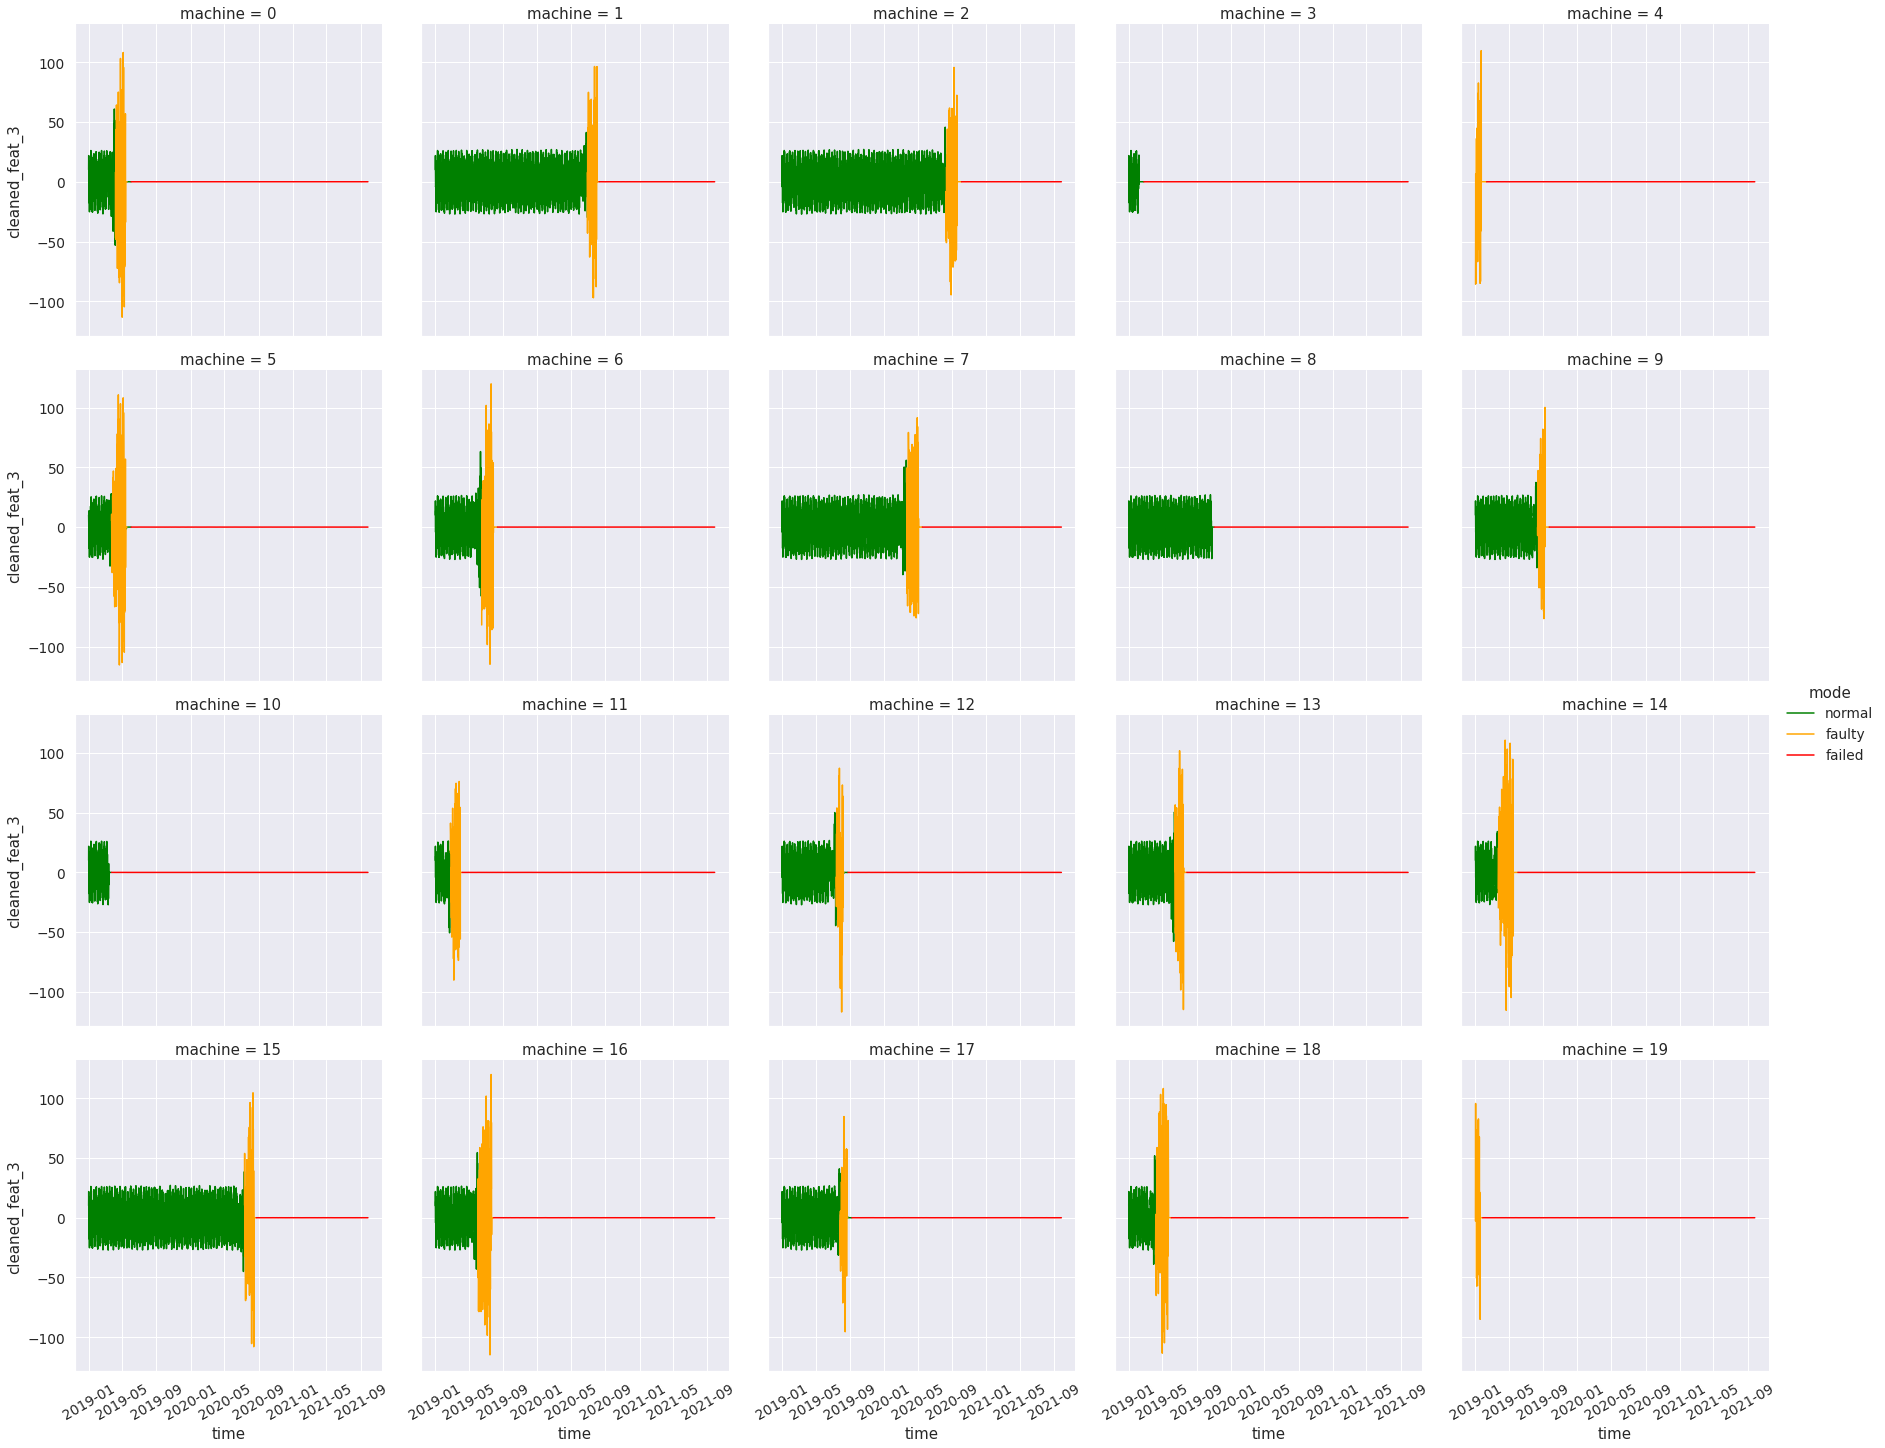

In [15]:
# figures 5a-5d. Cleaned data over time, facetted by machine. Separate figures for each feature. Colored by machine "mode".

## convert to pandas dataframe to use seaborn library. Reset index to enable ploting by time and machine
data_df = data.to_dataframe().reset_index()

## colors for modes
color_dict = dict({'normal':'green',
                  'faulty':'orange',
                  'failed': 'red'})

sns.set(font_scale = 1.25)
for cfeat, fig in zip(cleaned_feats, ['a','b','c','d']):
  plt.figure()
  plot = sns.relplot(x = 'time', y = cfeat, col = 'machine', data = data_df, col_wrap = 5, kind = 'line', hue = 'mode', palette=color_dict)
  for axes in plot.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
  plt.savefig(PARENT_DIR + '/figures/5'+ fig, bbox_inches = "tight")
sns.set()

